In [1]:
# !pip install -U denoiser

In [2]:
from IPython.display import (
    Audio, 
    display
)
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import librosa
import torch
import torchaudio
from denoiser import pretrained
from denoiser.dsp import convert_audio

# Device

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

---
# Model

In [4]:
# model = pretrained.dns64().cuda()
model = pretrained.dns64().to(device)

# Audio data needs to be resampled to the sampling rate to which the model was trained on.
model_sampling_rate: int = model.sample_rate
print(f"sampling rate that the model used at training is [{model_sampling_rate}].")

sampling rate that the model used at training is [16000].


---
# Audio data

In [5]:
# Downloading a test file
# !wget https://facebookresearch.github.io/denoiser/audio/noisy/alex_noisy.mp3

In [6]:
# data, data_sampling_rate = torchaudio.load('alex_noisy.mp3')
data, data_sampling_rate = torchaudio.load("/home/eml/home/repository/data/ml/LibriSpeechNoiseDataset/train/19-198-0003.wav")
print(f"sampling rate that the data is recorded is [{data_sampling_rate}].")

sampling rate that the data is recorded is [16000].


##  Resample the data for the model

In [7]:
resampled = convert_audio(wav=data.cuda(), from_samplerate=data_sampling_rate, to_samplerate=model_sampling_rate, channels=model.chin)
display(Audio(resampled.cpu().numpy(), rate=model.sample_rate))

## Mel Scale of the data to denoise

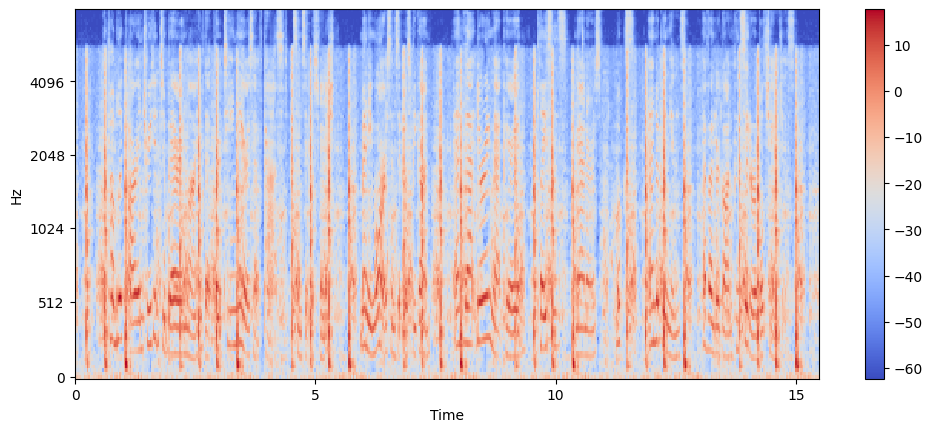

In [11]:
S = librosa.feature.melspectrogram(
    y=np.squeeze(resampled.cpu().numpy()), 
    sr=model_sampling_rate, 
    n_mels=128,
    n_fft=1024,
    hop_length=512,
    fmax=model_sampling_rate/2
)
S_dB = librosa.power_to_db(S)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_dB, x_axis="time", y_axis="mel", sr=model_sampling_rate, fmax=model_sampling_rate/2)
plt.colorbar()

---
# Denoise

In [13]:
with torch.no_grad():
    denoised = model(resampled[None])[0]

display(Audio(denoised.data.cpu().numpy(), rate=model_sample_rate))

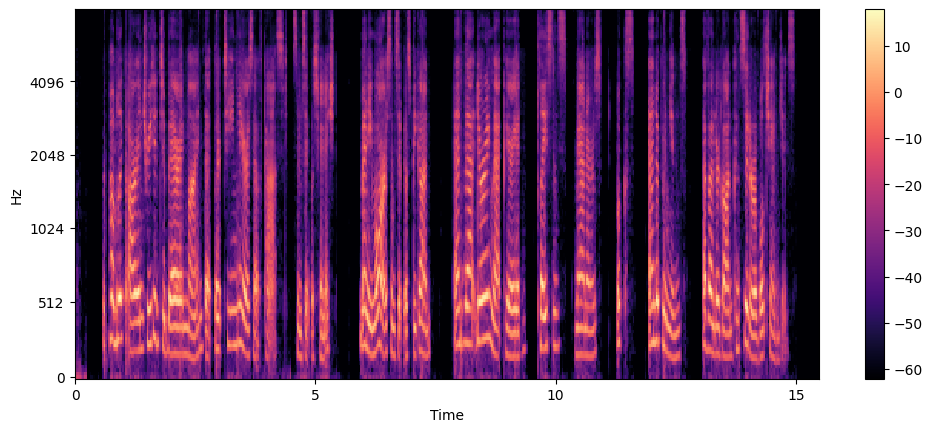

In [14]:
S = librosa.feature.melspectrogram(
    y=np.squeeze(denoised.cpu().numpy()), 
    sr=model_sampling_rate, 
    n_mels=128,
    n_fft=1024,
    hop_length=512,
    fmax=model_sampling_rate/2
)
S_dB = librosa.power_to_db(S)

plt.figure().set_figwidth(12)
librosa.display.specshow(S_dB, x_axis="time", y_axis="mel", sr=model_sampling_rate, fmax=model_sampling_rate/2)
plt.colorbar()